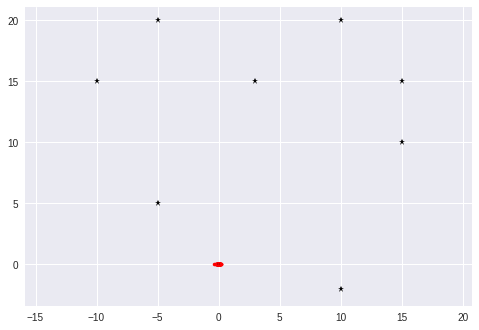

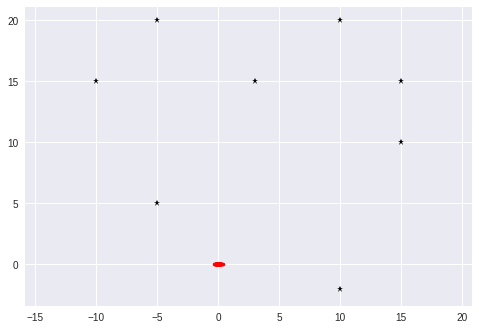

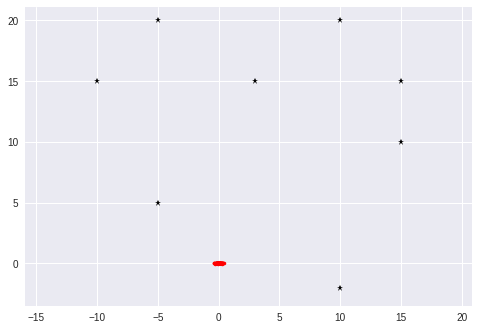

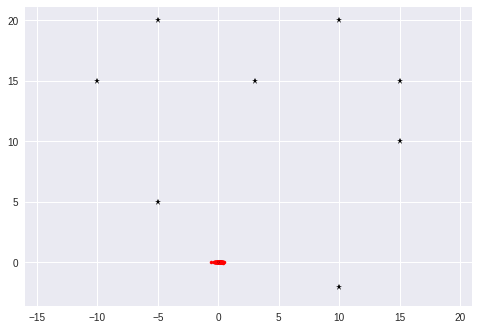

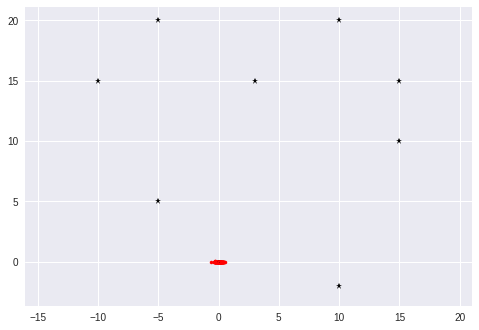

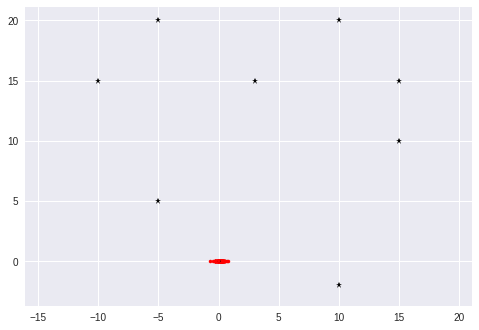

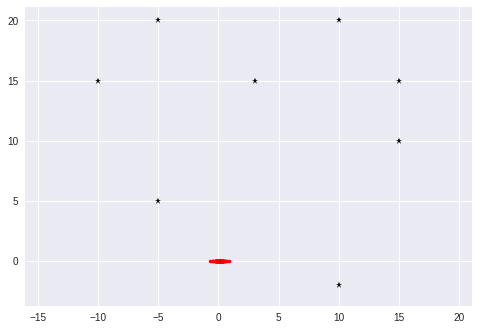

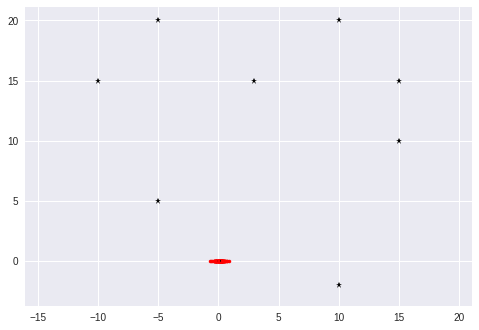

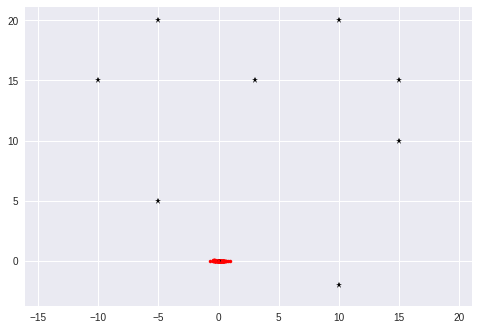

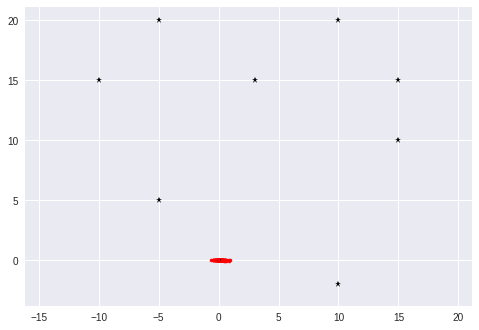

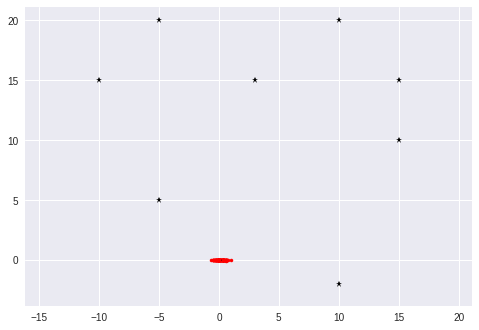

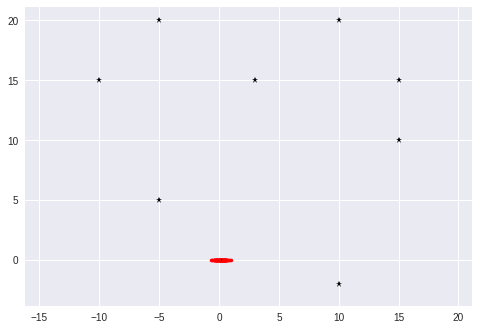

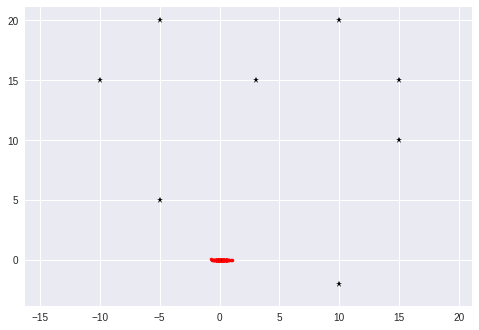

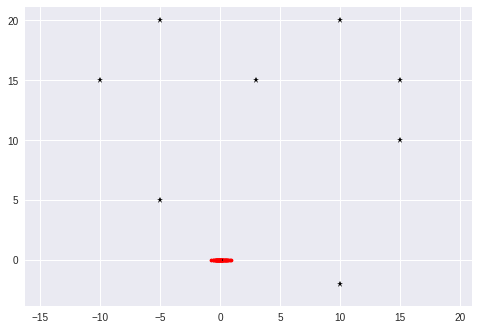

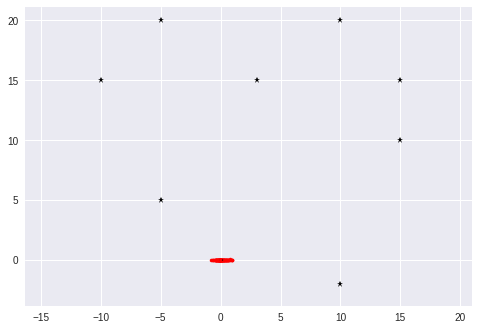

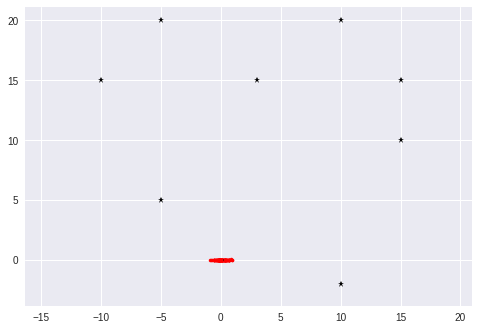

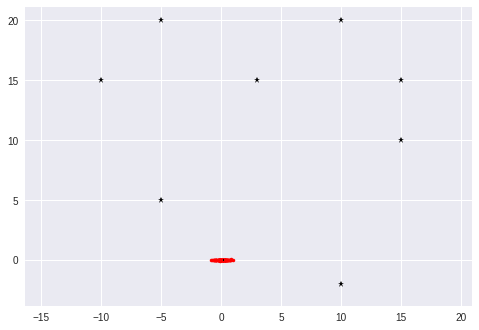

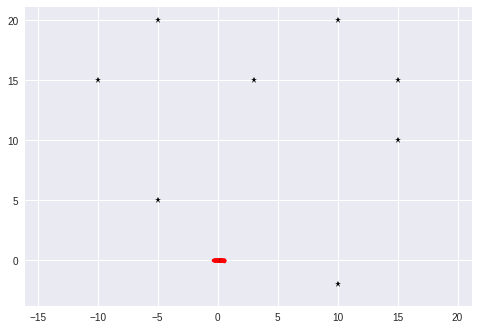

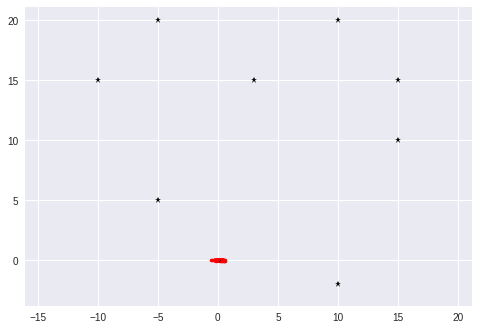

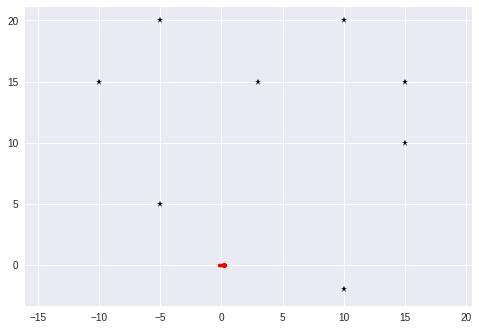

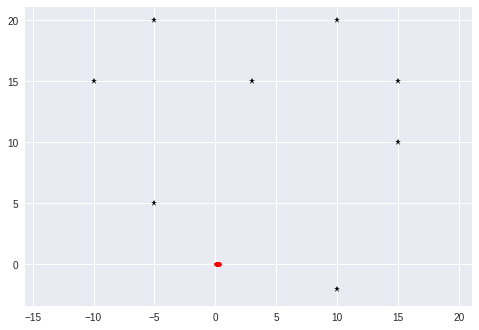

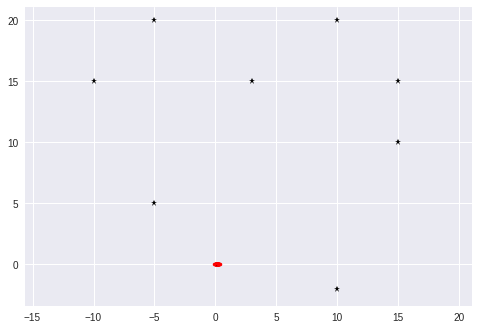

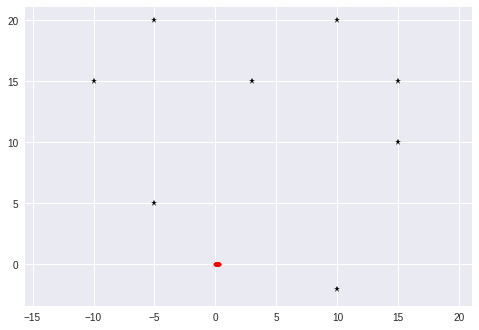

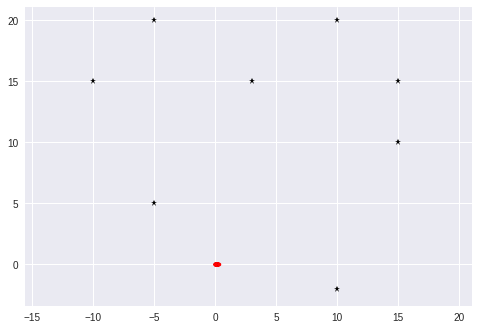

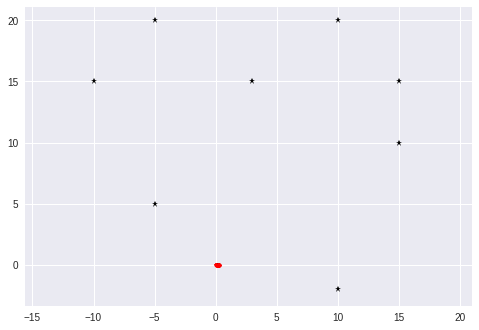

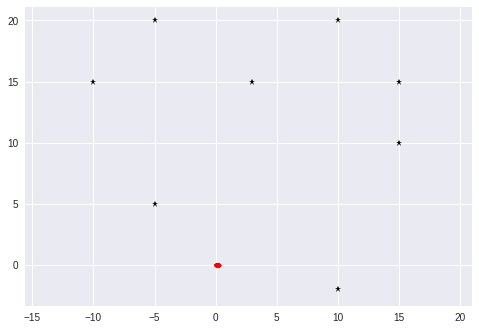

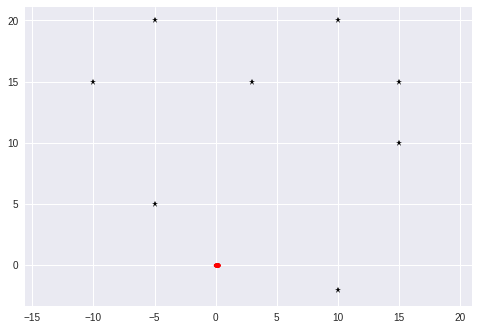

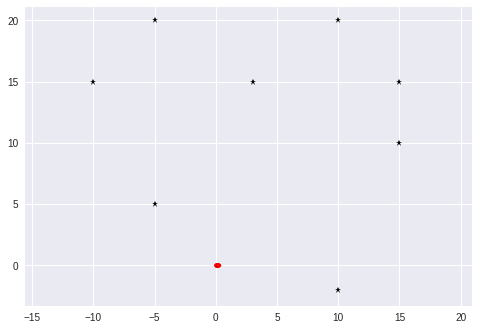

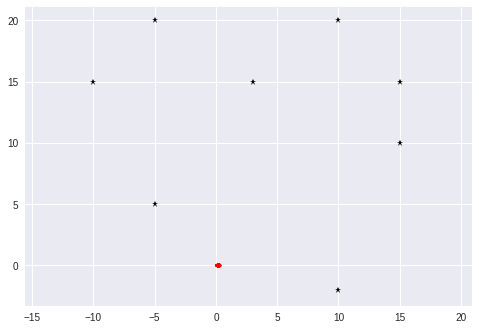

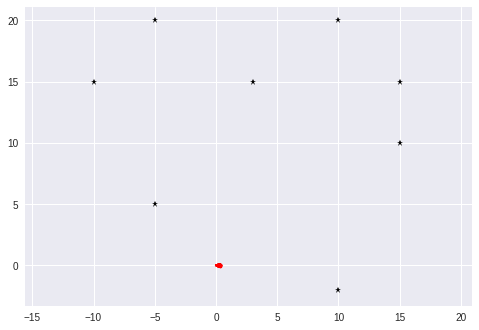

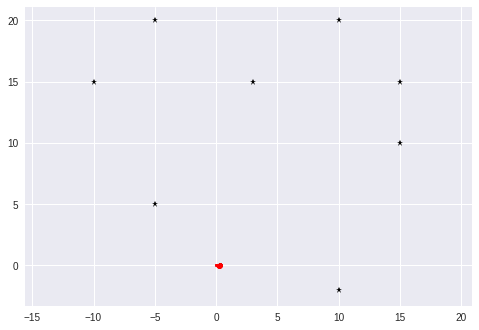

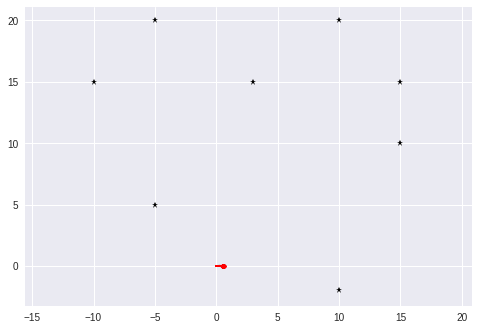

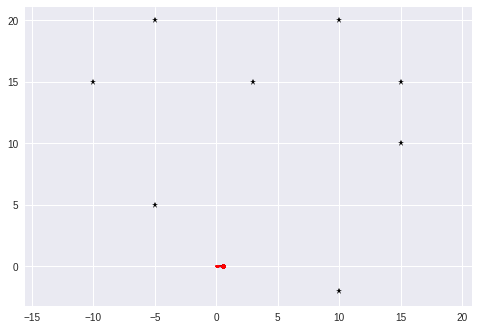

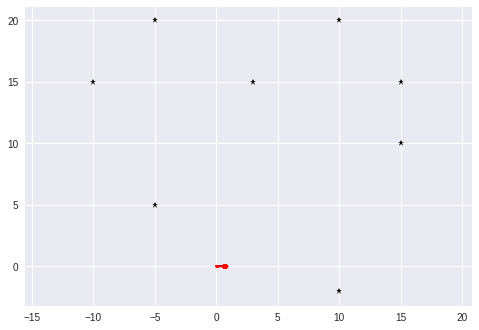

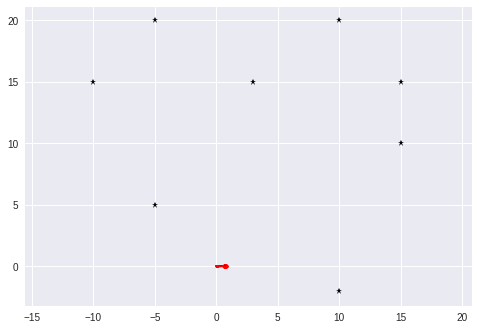

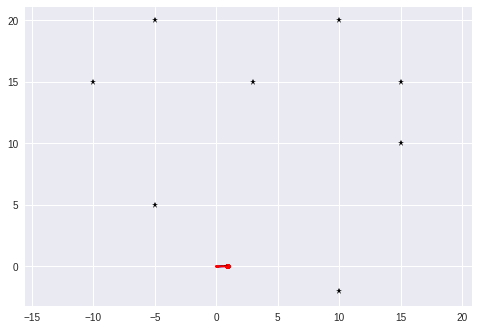

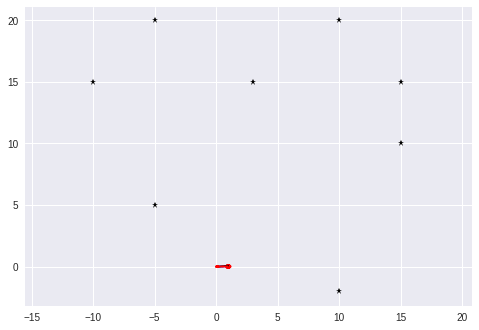

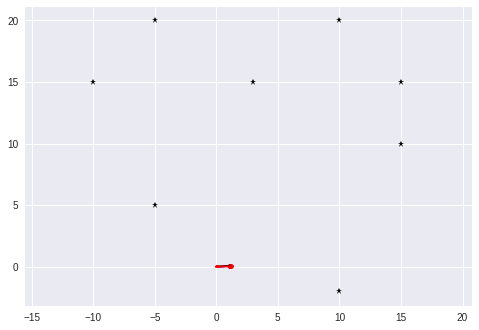

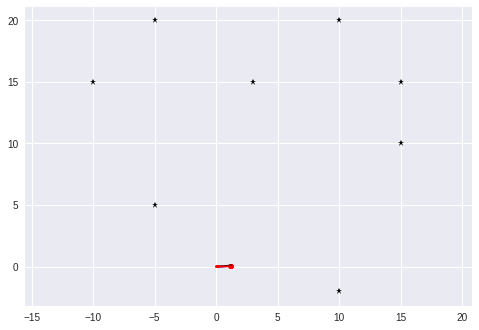

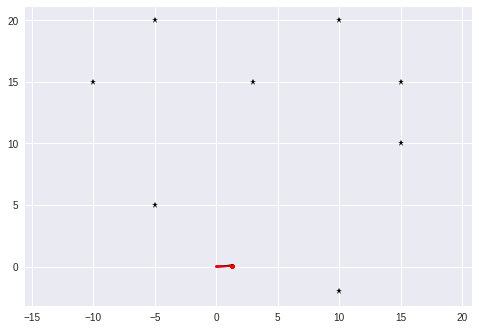

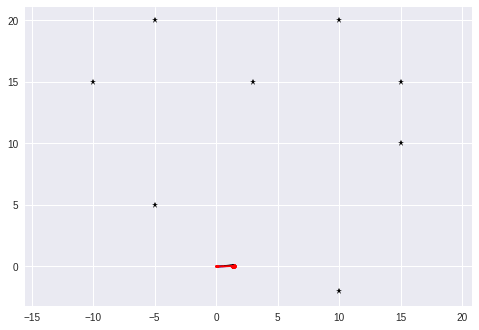

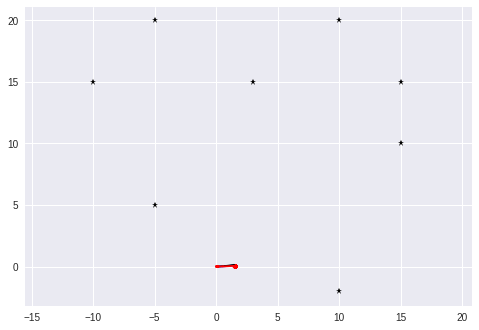

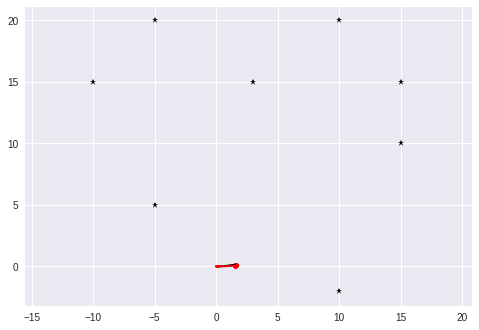

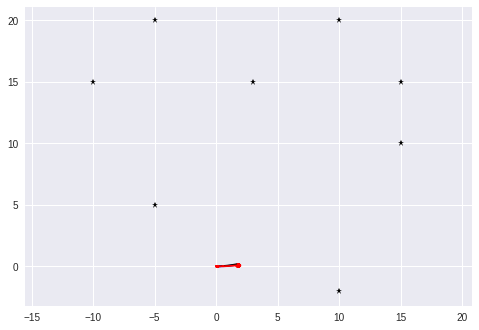

KeyboardInterrupt: ignored

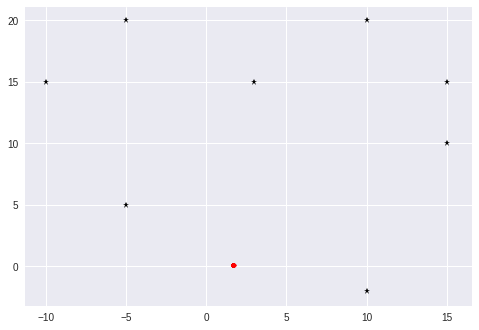

In [0]:
"""

FastSLAM 1.0 example

author: Atsushi Sakai (@Atsushi_twi)

"""

import numpy as np
import math
import matplotlib.pyplot as plt


# Fast SLAM covariance
Q = np.diag([3.0, math.radians(10.0)])**2
R = np.diag([1.0, math.radians(20.0)])**2

#  Simulation parameter
Qsim = np.diag([0.3, math.radians(2.0)])**2
Rsim = np.diag([0.5, math.radians(10.0)])**2
OFFSET_YAWRATE_NOISE = 0.01

DT = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]
MAX_RANGE = 20.0  # maximum observation range
M_DIST_TH = 2.0  # Threshold of Mahalanobis distance for data association.
STATE_SIZE = 3  # State size [x,y,yaw]
LM_SIZE = 2  # LM srate size [x,y]
N_PARTICLE = 100  # number of particle
NTH = N_PARTICLE / 1.5  # Number of particle for re-sampling

show_animation = True


class Particle:

    def __init__(self, N_LM):
        self.w = 1.0 / N_PARTICLE
        self.x = 0.0
        self.y = 0.0
        self.yaw = 0.0
        # landmark x-y positions
        self.lm = np.matrix(np.zeros((N_LM, LM_SIZE)))
        # landmark position covariance
        self.lmP = np.matrix(np.zeros((N_LM * LM_SIZE, LM_SIZE)))


def fast_slam1(particles, u, z):

    particles = predict_particles(particles, u)

    particles = update_with_observation(particles, z)

    particles = resampling(particles)

    return particles


def normalize_weight(particles):

    sumw = sum([p.w for p in particles])

    try:
        for i in range(N_PARTICLE):
            particles[i].w /= sumw
    except ZeroDivisionError:
        for i in range(N_PARTICLE):
            particles[i].w = 1.0 / N_PARTICLE

        return particles

    return particles


def calc_final_state(particles):

    xEst = np.zeros((STATE_SIZE, 1))

    particles = normalize_weight(particles)

    for i in range(N_PARTICLE):
        xEst[0, 0] += particles[i].w * particles[i].x
        xEst[1, 0] += particles[i].w * particles[i].y
        xEst[2, 0] += particles[i].w * particles[i].yaw

    xEst[2, 0] = pi_2_pi(xEst[2, 0])
    #  print(xEst)

    return xEst


def predict_particles(particles, u):

    for i in range(N_PARTICLE):
        px = np.zeros((STATE_SIZE, 1))
        px[0, 0] = particles[i].x
        px[1, 0] = particles[i].y
        px[2, 0] = particles[i].yaw
        ud = u + (np.matrix(np.random.randn(1, 2)) * R).T  # add noise
        px = motion_model(px, ud)
        particles[i].x = px[0, 0]
        particles[i].y = px[1, 0]
        particles[i].yaw = px[2, 0]

    return particles


def add_new_lm(particle, z, Q):

    r = z[0, 0]
    b = z[0, 1]
    lm_id = int(z[0, 2])

    s = math.sin(pi_2_pi(particle.yaw + b))
    c = math.cos(pi_2_pi(particle.yaw + b))

    particle.lm[lm_id, 0] = particle.x + r * c
    particle.lm[lm_id, 1] = particle.y + r * s

    # covariance
    Gz = np.matrix([[c, -r * s],
                    [s, r * c]])

    particle.lmP[2 * lm_id:2 * lm_id + 2] = Gz * Q * Gz.T

    return particle


def compute_jacobians(particle, xf, Pf, Q):
    dx = xf[0, 0] - particle.x
    dy = xf[1, 0] - particle.y
    d2 = dx**2 + dy**2
    d = math.sqrt(d2)

    zp = np.matrix([[d, pi_2_pi(math.atan2(dy, dx) - particle.yaw)]]).T

    Hv = np.matrix([[-dx / d, -dy / d, 0.0],
                    [dy / d2, -dx / d2, -1.0]])

    Hf = np.matrix([[dx / d, dy / d],
                    [-dy / d2, dx / d2]])

    Sf = Hf * Pf * Hf.T + Q

    return zp, Hv, Hf, Sf


def update_KF_with_cholesky(xf, Pf, v, Q, Hf):
    PHt = Pf * Hf.T
    S = Hf * PHt + Q

    S = (S + S.T) * 0.5
    SChol = np.linalg.cholesky(S).T
    SCholInv = np.linalg.inv(SChol)
    W1 = PHt * SCholInv
    W = W1 * SCholInv.T

    x = xf + W * v
    P = Pf - W1 * W1.T

    return x, P


def update_landmark(particle, z, Q):

    lm_id = int(z[0, 2])
    xf = np.matrix(particle.lm[lm_id, :]).T
    Pf = np.matrix(particle.lmP[2 * lm_id:2 * lm_id + 2, :])

    zp, Hv, Hf, Sf = compute_jacobians(particle, xf, Pf, Q)

    dz = z[0, 0: 2].T - zp
    dz[1, 0] = pi_2_pi(dz[1, 0])

    xf, Pf = update_KF_with_cholesky(xf, Pf, dz, Q, Hf)

    particle.lm[lm_id, :] = xf.T
    particle.lmP[2 * lm_id:2 * lm_id + 2, :] = Pf

    return particle


def compute_weight(particle, z, Q):

    lm_id = int(z[0, 2])
    xf = np.matrix(particle.lm[lm_id, :]).T
    Pf = np.matrix(particle.lmP[2 * lm_id:2 * lm_id + 2])
    zp, Hv, Hf, Sf = compute_jacobians(particle, xf, Pf, Q)

    dx = z[0, 0: 2].T - zp
    dx[1, 0] = pi_2_pi(dx[1, 0])

    S = particle.lmP[2 * lm_id:2 * lm_id + 2]
    try:
        invS = np.linalg.inv(S)
    except np.linalg.linalg.LinAlgError:
        print("singuler")
        return 1.0

    num = math.exp(-0.5 * dx.T * invS * dx)
    den = 2.0 * math.pi * math.sqrt(np.linalg.det(S))

    w = num / den

    return w


def update_with_observation(particles, z):

    for iz in range(len(z[:, 0])):

        lmid = int(z[iz, 2])

        for ip in range(N_PARTICLE):
            # new landmark
            if abs(particles[ip].lm[lmid, 0]) <= 0.01:
                particles[ip] = add_new_lm(particles[ip], z[iz, :], Q)
            # known landmark
            else:
                w = compute_weight(particles[ip], z[iz, :], Q)
                particles[ip].w *= w
                particles[ip] = update_landmark(particles[ip], z[iz, :], Q)

    return particles


def resampling(particles):
    """
    low variance re-sampling
    """

    particles = normalize_weight(particles)

    pw = []
    for i in range(N_PARTICLE):
        pw.append(particles[i].w)

    pw = np.matrix(pw)

    Neff = 1.0 / (pw * pw.T)[0, 0]  # Effective particle number
    #  print(Neff)

    if Neff < NTH:  # resampling
        wcum = np.cumsum(pw)
        base = np.cumsum(pw * 0.0 + 1 / N_PARTICLE) - 1 / N_PARTICLE
        resampleid = base + np.random.rand(base.shape[1]) / N_PARTICLE

        inds = []
        ind = 0
        for ip in range(N_PARTICLE):
            while ((ind < wcum.shape[1] - 1) and (resampleid[0, ip] > wcum[0, ind])):
                ind += 1
            inds.append(ind)

        tparticles = particles[:]
        for i in range(len(inds)):
            particles[i].x = tparticles[inds[i]].x
            particles[i].y = tparticles[inds[i]].y
            particles[i].yaw = tparticles[inds[i]].yaw
            particles[i].lm = tparticles[inds[i]].lm[:, :]
            particles[i].lmP = tparticles[inds[i]].lmP[:, :]
            particles[i].w = 1.0 / N_PARTICLE

    return particles


def calc_input(time):

    if time <= 3.0:
        v = 0.0
        yawrate = 0.0
    else:
        v = 1.0  # [m/s]
        yawrate = 0.1  # [rad/s]

    u = np.matrix([v, yawrate]).T

    return u


def observation(xTrue, xd, u, RFID):

    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    z = np.matrix(np.zeros((0, 3)))

    for i in range(len(RFID[:, 0])):

        dx = RFID[i, 0] - xTrue[0, 0]
        dy = RFID[i, 1] - xTrue[1, 0]
        d = math.sqrt(dx**2 + dy**2)
        angle = pi_2_pi(math.atan2(dy, dx) - xTrue[2, 0])
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * Qsim[0, 0]  # add noise
            anglen = angle + np.random.randn() * Qsim[1, 1]  # add noise
            zi = np.matrix([dn, pi_2_pi(anglen), i])
            z = np.vstack((z, zi))

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * Rsim[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Rsim[1, 1] + OFFSET_YAWRATE_NOISE
    ud = np.matrix([ud1, ud2]).T

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud


def motion_model(x, u):

    F = np.matrix([[1.0, 0, 0],
                   [0, 1.0, 0],
                   [0, 0, 1.0]])

    B = np.matrix([[DT * math.cos(x[2, 0]), 0],
                   [DT * math.sin(x[2, 0]), 0],
                   [0.0, DT]])

    x = F * x + B * u

    x[2, 0] = pi_2_pi(x[2, 0])

    return x


def pi_2_pi(angle):
    while(angle > math.pi):
        angle = angle - 2.0 * math.pi

    while(angle < -math.pi):
        angle = angle + 2.0 * math.pi

    return angle


def main():
    #print(__file__ + " start!!")

    time = 0.0

    # RFID positions [x, y]
    RFID = np.array([[10.0, -2.0],
                     [15.0, 10.0],
                     [15.0, 15.0],
                     [10.0, 20.0],
                     [3.0, 15.0],
                     [-5.0, 20.0],
                     [-5.0, 5.0],
                     [-10.0, 15.0]
                     ])
    N_LM = RFID.shape[0]

    # State Vector [x y yaw v]'
    xEst = np.matrix(np.zeros((STATE_SIZE, 1)))
    xTrue = np.matrix(np.zeros((STATE_SIZE, 1)))

    xDR = np.matrix(np.zeros((STATE_SIZE, 1)))  # Dead reckoning

    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue

    particles = [Particle(N_LM) for i in range(N_PARTICLE)]

    while SIM_TIME >= time:
        time += DT
        u = calc_input(time)

        xTrue, z, xDR, ud = observation(xTrue, xDR, u, RFID)

        particles = fast_slam1(particles, ud, z)

        xEst = calc_final_state(particles)

        x_state = xEst[0: STATE_SIZE]

        # store data history
        hxEst = np.hstack((hxEst, x_state))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))

        if show_animation:
            plt.cla()
            plt.plot(RFID[:, 0], RFID[:, 1], "*k")

            for i in range(N_PARTICLE):
                plt.plot(particles[i].x, particles[i].y, ".r")
                plt.plot(particles[i].lm[:, 0], particles[i].lm[:, 1], "xb")

            plt.plot(np.array(hxTrue[0, :]).flatten(),
                     np.array(hxTrue[1, :]).flatten(), "-b")
            plt.plot(np.array(hxDR[0, :]).flatten(),
                     np.array(hxDR[1, :]).flatten(), "-k")
            plt.plot(np.array(hxEst[0, :]).flatten(),
                     np.array(hxEst[1, :]).flatten(), "-r")

            plt.plot(xEst[0], xEst[1], "xk")
            plt.axis("equal")
            plt.grid(True)
            plt.pause(0.001)


if __name__ == '__main__':
    main()

# Graph SLAM

In [0]:
# graph SLAM
import numpy as np
import math
import copy
import itertools
import matplotlib.pyplot as plt


In [0]:

#  Simulation parameter
Qsim = np.diag([0.2, math.radians(1.0)])**2
Rsim = np.diag([0.1, math.radians(10.0)])**2

DT = 2.0  # time tick [s]
SIM_TIME = 100.0  # simulation time [s]
MAX_RANGE = 30.0  # maximum observation range
STATE_SIZE = 3  # State size [x,y,yaw]

# Covariance parameter of Graph Based SLAM
C_SIGMA1 = 0.1
C_SIGMA2 = 0.1
C_SIGMA3 = math.radians(1.0)

MAX_ITR = 20  # Maximum iteration

show_graph_dtime = 20.0  # [s]
show_animation = True


In [0]:
class Edge():

    def __init__(self):
        self.e = np.zeros((3, 1))
        self.omega = np.zeros((3, 3))  # information matrix
        self.d1 = 0.0
        self.d2 = 0.0
        self.yaw1 = 0.0
        self.yaw2 = 0.0
        self.angle1 = 0.0
        self.angle2 = 0.0
        self.id1 = 0
        self.id2 = 0


def cal_observation_sigma(d):

    sigma = np.zeros((3, 3))
    sigma[0, 0] = C_SIGMA1**2
    sigma[1, 1] = C_SIGMA2**2
    sigma[2, 2] = C_SIGMA3**2

    return sigma


def calc_rotational_matrix(angle):

    Rt = np.matrix([[math.cos(angle), -math.sin(angle), 0],
                    [math.sin(angle), math.cos(angle), 0],
                    [0, 0, 1.0]])
    return Rt


def calc_edge(x1, y1, yaw1, x2, y2, yaw2, d1,
              angle1, phi1, d2, angle2, phi2, t1, t2):
    edge = Edge()

    tangle1 = pi_2_pi(yaw1 + angle1)
    tangle2 = pi_2_pi(yaw2 + angle2)
    tmp1 = d1 * math.cos(tangle1)
    tmp2 = d2 * math.cos(tangle2)
    tmp3 = d1 * math.sin(tangle1)
    tmp4 = d2 * math.sin(tangle2)

    edge.e[0, 0] = x2 - x1 - tmp1 + tmp2
    edge.e[1, 0] = y2 - y1 - tmp3 + tmp4
    hyaw = phi1 - phi2 + angle1 - angle2
    edge.e[2, 0] = pi_2_pi(yaw2 - yaw1 - hyaw)

    Rt1 = calc_rotational_matrix(tangle1)
    Rt2 = calc_rotational_matrix(tangle2)

    sig1 = cal_observation_sigma(d1)
    sig2 = cal_observation_sigma(d2)

    edge.omega = np.linalg.inv(Rt1 * sig1 * Rt1.T + Rt2 * sig2 * Rt2.T)

    edge.d1, edge.d2 = d1, d2
    edge.yaw1, edge.yaw2 = yaw1, yaw2
    edge.angle1, edge.angle2 = angle1, angle2
    edge.id1, edge.id2 = t1, t2

    return edge


def calc_edges(xlist, zlist):

    edges = []
    cost = 0.0
    zids = list(itertools.combinations(range(len(zlist)), 2))

    for (t1, t2) in zids:
        x1, y1, yaw1 = xlist[0, t1], xlist[1, t1], xlist[2, t1]
        x2, y2, yaw2 = xlist[0, t2], xlist[1, t2], xlist[2, t2]

        if zlist[t1] is None or zlist[t2] is None:
            continue  # No observation

        for iz1 in range(len(zlist[t1][:, 0])):
            for iz2 in range(len(zlist[t2][:, 0])):
                if zlist[t1][iz1, 3] == zlist[t2][iz2, 3]:
                    d1 = zlist[t1][iz1, 0]
                    angle1, phi1 = zlist[t1][iz1, 1], zlist[t1][iz1, 2]
                    d2 = zlist[t2][iz2, 0]
                    angle2, phi2 = zlist[t2][iz2, 1], zlist[t2][iz2, 2]

                    edge = calc_edge(x1, y1, yaw1, x2, y2, yaw2, d1,
                                     angle1, phi1, d2, angle2, phi2, t1, t2)

                    edges.append(edge)
                    cost += (edge.e.T * edge.omega * edge.e)[0, 0]

    print("cost:", cost, ",nedge:", len(edges))
    return edges


def calc_jacobian(edge):
    t1 = edge.yaw1 + edge.angle1
    A = np.matrix([[-1.0, 0, edge.d1 * math.sin(t1)],
                   [0, -1.0, -edge.d1 * math.cos(t1)],
                   [0, 0, -1.0]])

    t2 = edge.yaw2 + edge.angle2
    B = np.matrix([[1.0, 0, -edge.d2 * math.sin(t2)],
                   [0, 1.0, edge.d2 * math.cos(t2)],
                   [0, 0, 1.0]])

    return A, B


def fill_H_and_b(H, b, edge):

    A, B = calc_jacobian(edge)

    id1 = edge.id1 * STATE_SIZE
    id2 = edge.id2 * STATE_SIZE

    H[id1:id1 + STATE_SIZE, id1:id1 + STATE_SIZE] += A.T * edge.omega * A
    H[id1:id1 + STATE_SIZE, id2:id2 + STATE_SIZE] += A.T * edge.omega * B
    H[id2:id2 + STATE_SIZE, id1:id1 + STATE_SIZE] += B.T * edge.omega * A
    H[id2:id2 + STATE_SIZE, id2:id2 + STATE_SIZE] += B.T * edge.omega * B

    b[id1:id1 + STATE_SIZE, 0] += (A.T * edge.omega * edge.e)
    b[id2:id2 + STATE_SIZE, 0] += (B.T * edge.omega * edge.e)

    return H, b


def graph_based_slam(x_init, hz):
    print("start graph based slam")

    zlist = copy.deepcopy(hz)
    zlist.insert(1, zlist[0])

    x_opt = copy.deepcopy(x_init)
    nt = x_opt.shape[1]
    n = nt * STATE_SIZE

    for itr in range(MAX_ITR):
        edges = calc_edges(x_opt, zlist)

        H = np.matrix(np.zeros((n, n)))
        b = np.matrix(np.zeros((n, 1)))

        for edge in edges:
            H, b = fill_H_and_b(H, b, edge)

        # to fix origin
        H[0:STATE_SIZE, 0:STATE_SIZE] += np.identity(STATE_SIZE)

        dx = - np.linalg.inv(H).dot(b)

        for i in range(nt):
            x_opt[0:3, i] += dx[i * 3:i * 3 + 3, 0]

        diff = dx.T.dot(dx)
        print("iteration: %d, diff: %f" % (itr + 1, diff))
        if diff < 1.0e-5:
            break

    return x_opt


def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.matrix([v, yawrate]).T
    return u


def observation(xTrue, xd, u, RFID):

    xTrue = motion_model(xTrue, u)

    # add noise to gps x-y
    z = np.matrix(np.zeros((0, 4)))

    for i in range(len(RFID[:, 0])):

        dx = RFID[i, 0] - xTrue[0, 0]
        dy = RFID[i, 1] - xTrue[1, 0]
        d = math.sqrt(dx**2 + dy**2)
        angle = pi_2_pi(math.atan2(dy, dx)) - xTrue[2, 0]
        phi = pi_2_pi(math.atan2(dy, dx))
        if d <= MAX_RANGE:
            dn = d + np.random.randn() * Qsim[0, 0]  # add noise
            anglen = angle + np.random.randn() * Qsim[1, 1]  # add noise
            zi = np.matrix([dn, anglen, phi, i])
            z = np.vstack((z, zi))

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * Rsim[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Rsim[1, 1]
    ud = np.matrix([ud1, ud2]).T

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud


def motion_model(x, u):

    F = np.matrix([[1.0, 0, 0],
                   [0, 1.0, 0],
                   [0, 0, 1.0]])

    B = np.matrix([[DT * math.cos(x[2, 0]), 0],
                   [DT * math.sin(x[2, 0]), 0],
                   [0.0, DT]])

    x = F * x + B * u

    return x


def pi_2_pi(angle):
    return (angle + math.pi) % (2*math.pi) - math.pi




In [0]:
def main():
    #print(__file__ + " start!!")

    time = 0.0

    # RFID positions [x, y, yaw]
    RFID = np.array([[10.0, -2.0, 0.0],
                     [15.0, 10.0, 0.0],
                     [3.0, 15.0, 0.0],
                     [-5.0, 20.0, 0.0],
                     [-5.0, 5.0, 0.0]
                     ])

    # State Vector [x y yaw v]'
    xTrue = np.matrix(np.zeros((STATE_SIZE, 1)))
    xDR = np.matrix(np.zeros((STATE_SIZE, 1)))  # Dead reckoning

    # history
    hxTrue = xTrue
    hxDR = xTrue
    hz = []
    dtime = 0.0

    while SIM_TIME >= time:
        time += DT
        dtime += DT
        u = calc_input()

        xTrue, z, xDR, ud = observation(xTrue, xDR, u, RFID)

        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz.append(z)

        if dtime >= show_graph_dtime:
            x_opt = graph_based_slam(hxDR, hz)
            dtime = 0.0

            if show_animation:
                plt.cla()

                plt.plot(RFID[:, 0], RFID[:, 1], "*k")

                plt.plot(np.array(hxTrue[0, :]).flatten(),
                         np.array(hxTrue[1, :]).flatten(), "-b")
                plt.plot(np.array(hxDR[0, :]).flatten(),
                         np.array(hxDR[1, :]).flatten(), "-k")
                plt.plot(np.array(x_opt[0, :]).flatten(),
                         np.array(x_opt[1, :]).flatten(), "-r")
                plt.axis("equal")
                plt.grid(True)
                plt.title("Time" + str(time)[0:5])
                plt.pause(1.0)


if __name__ == '__main__':
    main()

In [0]:
import numpy as np

def euler_to_quaternion(angles):
    roll = angles[0]
    pitch = angles[1]
    yaw = angles[2]
    
    sinroll = np.sin(roll/2)
    cosroll = np.cos(roll/2)
    
    sinpitch = np.sin(pitch/2)
    cospitch = np.cos(pitch/2)
    
    sinyaw = np.sin(yaw/2)
    cosyaw = np.cos(yaw/2)
    
    a = cosroll * cospitch * cosyaw + sinroll * sinpitch * sinyaw
    b = sinroll * cospitch * cosyaw - cosroll * sinpitch * sinyaw
    c = cosroll * sinpitch * cosyaw + sinroll * cospitch * sinyaw
    d = cosroll * cospitch * sinyaw - sinroll * sinpitch * cosyaw
    
    q = [a,b,c,d]
    
    return q
    

def quaternion_to_euler(quaternion):
    #return a numpy array of
    # 3 element representing the euler angles [roll, pitch, yaw]

    a = quaternion[0]
    b = quaternion[1]
    c = quaternion[2]
    d = quaternion[3]
    
    roll = np.arctan2(2 * (a*b + c*d), 1 - 2 * (b**2 + c**2))
    pitch = np.arcsin(2* (a*c - d*b))
    yaw = np.arctan2(2* (a*d + b*c), 1 - 2 * (c**2 + d**2))
    
    angles = [roll, pitch, yaw]
    return angles


In [4]:
euler = np.array([np.deg2rad(90), np.deg2rad(30), np.deg2rad(0)])

q = euler_to_quaternion(euler) # should be [ 0.683  0.683  0.183 -0.183]
print(q)

assert np.allclose(euler, quaternion_to_euler(q))


[0.6830127018922194, 0.6830127018922193, 0.18301270189221933, -0.1830127018922193]
